In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import matplotlib.cm as cm
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
import cantera as ct 
import matplotlib as mpl
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = ["Times", "Times New Roman", "DejaVu Serif"]

import scipy
from scipy.linalg import null_space
import matplotlib.lines as mlines   # for creating custom legend lines


case_name = "case_NH3_0D"

line_arr = ('-', '--', '-.', ':')
color_arr = ('k', 'r', 'b', 'y', 'g', 'c', 'm')
symbol_arr = ('s', 'o', 'v', '^', '*')


In [2]:

# mech = "mechs/NH3_otomo.cti"
mech = "gri30.yaml"

T0, P0 = 1200, ct.one_atm
phi, fuel, oxid = 1.0, "NH3:0.8, H2:0.2", "O2:0.21, N2:0.79"

def simulate(gas, tot=1e-3):
    """Integrate until time < tot, returning a SolutionArray with .t for times."""
    r = ct.IdealGasConstPressureReactor(gas)
    sim = ct.ReactorNet([r])
    states = ct.SolutionArray(gas, extra=['t'])
    try:
        while sim.time < tot:
            sim.step()
            states.append(r.thermo.state, t=sim.time)
    except:
        print("Error Occurred In Cantera Solver!")
        return None
    return states

# -------------------------------------------------------------------
# 1) Initialize Cantera solution and element matrix
# -------------------------------------------------------------------
gas = ct.Solution(mech)
Ns = gas.n_species
Ne = gas.n_elements
Nr = gas.n_reactions

# B[i, j] = number of atoms of element j in species i
B = np.zeros((Ns, Ne))
for i_sp, sp in enumerate(gas.species()):
    for (key, val) in sp.composition.items():
        B[i_sp, gas.element_index(key)] = val

print("gas.element_names=", gas.element_names)
# -------------------------------------------------------------------
# 2) Equilibrium state
# -------------------------------------------------------------------
gas.TP = T0, P0

gas.set_equivalence_ratio(phi, fuel, oxid)
states_eq = simulate(gas, tot=100)
Xeq = states_eq.X[-1, :]  # last point = equilibrium
H0, P0 = gas.HP

print("H0=", gas.T)
print("P0=", P0)

# Assume total mixture = 1.0 mol
N_tot = 1.0
N0 = Xeq * N_tot  
# c = total number of each element at equilibrium
c = B.T @ N0  # shape: (Ne,)
print("C=",c)
# -------------------------------------------------------------------
# 3) Prepare for storing data across simulations
# -------------------------------------------------------------------
plt.figure(figsize=(4.93, 4.7))

all_times = []
all_xIDX  = []
all_xIDY  = []

# Indices for species we want to plot
idx = gas.species_index("N2")   
idy = gas.species_index("H2O")  

# Plot the equilibrium point as a reference (in terms of X eq)
plt.scatter(Xeq[idx], Xeq[idy], marker="o", color="k", zorder=10)

# -------------------------------------------------------------------
# 4) Loop over multiple sample perturbations
# -------------------------------------------------------------------
NSamples = 25 #25
for i_sample in range(NSamples):
    # Copy the equilibrium composition
    N_pert = Xeq.copy()
    a, b = (i_sample % 5) / 5, int(i_sample / 5) / 5  # Grid-based parameters

    # Example perturbation: remove some N2/H2O, add N/O2/H2
    N_ratio = N_pert[gas.species_index("N2")] * a / 20
    H_ratio = N_pert[gas.species_index("H2O")] * b
    N_pert[gas.species_index("N2")] -= N_ratio
    N_pert[gas.species_index("N")]  += N_ratio * 2
    
    N_pert[gas.species_index("H2O")] -= H_ratio
    N_pert[gas.species_index("O2")]  += H_ratio / 2
    N_pert[gas.species_index("H2")]  += H_ratio

    # Normalize total to 1.0
    N_pert /= N_pert.sum()

    # Run simulation from that perturbed state
    gas.HPX = H0, P0, N_pert
    states = simulate(gas)
    if states is None:
        continue

    # -----------------------------------------------------------------
    # 5) For each time-step in `states`, compute N = x_ildm * N_ave
    #    so that we preserve total # of atoms from c.sum()
    # -----------------------------------------------------------------
    for i_time in range(len(states.X)):
        x_ildm = states.X[i_time, :]              # current mole fractions
        product = B.T @ x_ildm                    # element totals for this state
        # c.sum() is the total # of atoms at equilibrium, product.sum() is at this state
        if product.sum() == 0:
            # Avoid divide by zero if extremely small fractions
            continue
        
        N_ave = c.sum() / product.sum()           # scale factor
        print("N_ave",N_ave)
        N_vector = x_ildm / N_ave                 # scaled "moles" preserving total atoms

        # Store data for plotting
        all_times.append(states.t[i_time])
        all_xIDX.append(N_vector[idx])
        all_xIDY.append(N_vector[idy])

# -------------------------------------------------------------------
# 6) Convert to arrays and mask by time intervals
# -------------------------------------------------------------------
all_times = np.array(all_times)
all_xIDX  = np.array(all_xIDX)
all_xIDY  = np.array(all_xIDY)

mask_red   = (all_times >= 0)    & (all_times < 1e-6)
mask_green = (all_times >= 1e-6) & (all_times < 1e-5)
mask_blue  = (all_times >= 1e-5) & (all_times < 1e-3)



NameError: name 'ct' is not defined

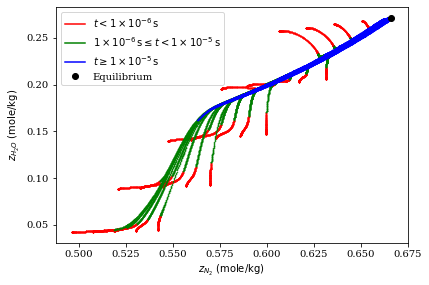

In [22]:
# -------------------------------------------------------------------
# 7) Plot results
# -------------------------------------------------------------------
# Plot the equilibrium point as a reference (in terms of X eq)
plt.scatter(Xeq[idx], Xeq[idy], marker="o", color="k", zorder=10)

plt.plot(all_xIDX[mask_red],   all_xIDY[mask_red],   'r.', markersize=1)
plt.plot(all_xIDX[mask_green], all_xIDY[mask_green], 'g.', markersize=1)
plt.plot(all_xIDX[mask_blue],  all_xIDY[mask_blue],  'b.', markersize=1)

line_red   = mlines.Line2D([], [], color='r', linestyle='-', label=r'$t < 1\times10^{-6}\,\mathrm{s}$')
line_green = mlines.Line2D([], [], color='g', linestyle='-', label=r'$1\times10^{-6}\,\mathrm{s} \leq t < 1\times10^{-5}\,\mathrm{s}$')
line_blue  = mlines.Line2D([], [], color='b', linestyle='-', label=r'$t \geq 1\times10^{-5}\,\mathrm{s}$')
eq_marker  = mlines.Line2D([], [], color='k', marker='o', linestyle='', label=r'Equilibrium')

plt.legend(handles=[line_red, line_green, line_blue, eq_marker], loc='upper left',fontsize=10)
plt.xlabel(r"$z_{N_2}\ (\mathrm{mole/kg})$", fontsize=10)
plt.ylabel(r"$z_{H_2O}\ (\mathrm{mole/kg})$", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()

plt.savefig("/data/ZhuXu/Cantera/CEMA/figs/NH3_manifold_new.pdf", bbox_inches='tight')
plt.show()

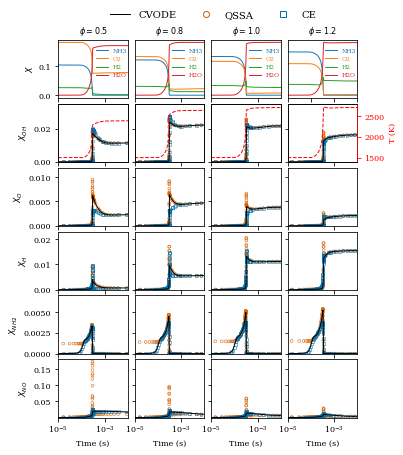

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- Paths and case info ---
QSSA_path = "../../figs/QSSA/data/"
RCCE_path = "../../figs/RCCE_fortran/data/"
data_dir  = "../../data"
case_name = "case_NH3_0D"
fig_dir = "../../figs/NH3_0Dignition"

# --- Plot styling arrays ---
line_arr   = ('-', '--', '-.', ':')
color_arr  = ('k', 'r', 'b', 'y', 'g', 'c', 'm')
symbol_arr = ('s', 'o', 'v', '^', '*')

target_case_assemble = [
    'N_HR_1',
    'N_HR_2',
    'N_HR_3',
    'N_HR_4',
]
name_case_assemble = [
    r'$\phi = 0.5$',
    r'$\phi = 0.8$',
    r'$\phi = 1.0$',
    r'$\phi = 1.2$',
]

# --- Top row species (left axis only) ---
top_row_left_cols = ['NH3', 'O2', 'H2', 'H2O']

# --- Lower rows ---
# 'CEM' will be in the second row (with T on a twin y-axis), then 'OH' and 'NO'
# data_cols = [ 'OH', 'O', 'H', 'NO','CEM','Qdot']
data_cols = [ 'OH', 'O', 'H', 'NH2','NO']


# --- Parameters for scatter symbol edge colors ---
# qssa_marker_edge_color = 'blue'  # Parameter for QSSA symbol edge color
# ceq_marker_edge_color  = 'red'   # Parameter for CE (RCCE) symbol edge color


qssa_marker_edge_color = '#D55E00'  # Parameter for QSSA symbol edge color
ceq_marker_edge_color  = '#0072B2'   # Parameter for CE (RCCE) symbol edge color

x_range   = [1e-5, 1e-2]
T_range = [1400, 2800]  # Set the T range here

range_cols = {
    'CEM': (-6, 6),
    'OH': (0, 0.035 ),
    'O': (0, 1.2e-2),
    'H': (0, 2.3e-2),
    'NO': (1e-4, 0.18),
    'NH2': (0, 7e-3),
    'Qdot': (1e7, 5e10)
    }

log_cols   = {
    'Qdot': True,
}

plt.rcParams.update({'font.size': 8})

# Create subplots: top row + one row for each entry in data_cols
fig, axs = plt.subplots(len(data_cols) + 1, 
                        len(target_case_assemble),
                        figsize=(5.73, 1.1 * (len(data_cols) + 1))
                       )

########################################################################
# 1) Plot top row: species on left axis only
########################################################################
first_row_handles = []
first_row_labels  = []

for col_idx, target_case in enumerate(target_case_assemble):
    # Read the original CSV
    original_data_path = os.path.join(data_dir, case_name, target_case) + ".csv"
    df_original = pd.read_csv(original_data_path)
    t = df_original['t'].to_numpy()

    ax = axs[0, col_idx]

    # Plot the species in top_row_left_cols
    for col in top_row_left_cols:
        line, = ax.plot(
            t,
            df_original[col].to_numpy(),
            label=col,
            linestyle='-',
            linewidth=1.0
        )
        # Collect legend handles/labels only once (leftmost subplot)
        if col_idx == 0:
            first_row_handles.append(line)
            first_row_labels.append(col)

    ax.set_xscale('log')
    ax.set_xlim(x_range)
    ax.set_xticklabels([])  
    ax.set_title(name_case_assemble[col_idx], fontsize=8)

    if col_idx == 0:
        ax.set_ylabel(r'$X$', fontsize=8)

    # Remove y-ticks for columns > 0
    if col_idx != 0:
        ax.set_yticks([])

    # Only the rightmost top subplot might keep some X ticks
    if col_idx == len(target_case_assemble) - 1:
        ax.set_xticks([1e-5, 1e-4, 1e-3, 1e-2])

# Add a legend for the top row (species)
for col_idx in range(len(target_case_assemble)):
    ax = axs[0, col_idx]
    legend_1 = ax.legend(
        first_row_handles,
        first_row_labels,
        loc='upper center',
        ncol=1,
        fontsize=6,
        frameon=False,
        bbox_to_anchor=(0.76, 0.95)
    )
    # Sync color of legend text with the line color
    for text, line in zip(legend_1.get_texts(), legend_1.get_lines()):
        text.set_color(line.get_color())

########################################################################
# 2) Plot each of the lower rows: one row per data_col
#    Except that for 'CEM', we also plot 'T' on a twin y-axis.
########################################################################
for col_idx, target_case in enumerate(target_case_assemble):
    # CSV paths
    original_data_path = os.path.join(data_dir, case_name, target_case) + ".csv"
    rcce_data_path     = os.path.join(RCCE_path, case_name, target_case, "predicted_X.csv")
    qssa_data_path     = os.path.join(QSSA_path, case_name, target_case, "predicted_X.csv")

    df_original = pd.read_csv(original_data_path)
    df_rcce     = pd.read_csv(rcce_data_path)
    df_qssa     = pd.read_csv(qssa_data_path)

    t = df_original['t'].to_numpy()

    for row_idx, col in enumerate(data_cols):
        ax = axs[row_idx + 1, col_idx]  # row_idx+1 because row=0 was top

        # Plot CVODE for col (line plot)
        cvode_values = df_original[col].to_numpy()
        ax.plot(
            t,
            cvode_values,
            linestyle='-',
            linewidth=1,
            color='black',
            label='CVODE' if (col_idx == 0 and row_idx == 0) else ""
        )

        # Plot QSSA for col (scatter)
        if col in df_qssa.columns:
            qssa_values = df_qssa[col].to_numpy()
            ax.scatter(
                t[::25],
                qssa_values[::25],
                s=8,
                alpha=1,
                linewidths=0.5,
                marker='o',
                facecolors='none',
                edgecolors=qssa_marker_edge_color,
                label='QSSA' if (col_idx == 0 and row_idx == 0) else ""
            )

        # Plot RCCE (labeled as CE) for col (scatter)
        if col in df_rcce.columns:
            rcce_values = df_rcce[col].to_numpy()
            ax.scatter(
                t[::25],
                rcce_values[::25],
                s=8,
                linewidths=0.5,
                alpha=1,
                marker='s',
                facecolors='none',
                edgecolors=ceq_marker_edge_color,
                label='RCCE' if (col_idx == 0 and row_idx == 0) else ""
            )

        # SPECIAL CASE: If col == 'CEM', also plot T on the right axis
        if col == 'OH':
            ax_right = ax.twinx()
            # Plot T from df_original (CVODE)
            T_cvode = df_original['T'].to_numpy()
            line_T, = ax_right.plot(
                t,
                T_cvode,
                linestyle='--',
                linewidth=1,
                color='red',   # or any color you want for T
                label='T (CVODE)' if (col_idx == 0 and row_idx == 0) else ""
            )
            # Optionally, if you have T in QSSA or RCCE, you can plot them similarly:
            if 'T' in df_qssa.columns:
                ax_right.scatter(
                    t[::25],
                    df_qssa['T'].to_numpy()[::25],
                    s=5,
                    alpha=1,
                    marker='o',
                    facecolors='none',
                    edgecolors='red',
                    label='T (QSSA)' if (col_idx == 0 and row_idx == 0) else ""
                )
            if 'T' in df_rcce.columns:
                ax_right.scatter(
                    t[::25],
                    df_rcce['T'].to_numpy()[::25],
                    s=5,
                    alpha=1,
                    marker='s',
                    facecolors='none',
                    edgecolors='#D55E00',
                    label='T (RCCE)' if (col_idx == 0 and row_idx == 0) else ""
                )

            # Set the T y-axis range
            ax_right.set_ylim(T_range)


            if col_idx == len(target_case_assemble) - 1:
                ax_right.set_ylabel("T (K)", fontsize=8, color='red')
                # Color the spine and tick labels for consistency
                ax_right.spines['right'].set_color('red')
                ax_right.tick_params(axis='y', which='both', colors='red')
            else:
                ax_right.set_yticks([])

        # Format the left axis
        ax.set_xscale('log')
        ax.set_xlim(x_range)
        ax.set_ylim(range_cols[col])

        # Example: if col == 'Qdot', you might want log-scale in y
        if col == 'Qdot' and log_cols['Qdot'] == True:
            ax.set_yscale('log')
            
        # if col == 'NO':
        #     ax.set_yscale('log')
        # Only bottom row shows the x-axis label
        if row_idx == len(data_cols) - 1:
            ax.set_xlabel("Time (s)", fontsize=8)

        # Y-axis label only in the first column
        if col_idx == 0:
            if col == 'Qdot':
                ax.set_ylabel('HRR (J/kg/s)', fontsize=8)
            else:
                # Set the y-label as a LaTeX string: e.g., '$X_{OH}$' when col is 'OH'
                ax.set_ylabel(r'$X_{' + col + '}$', fontsize=8)

        # Remove y-labels if not the first column
        if col_idx != 0:
            ax.set_yticklabels([])

        # Remove x-ticklabels if not in the bottom-most row of data_cols
        if row_idx != len(data_cols) - 1:
            ax.set_xticklabels([])

########################################################################
# 3) Add a legend across the top for CVODE, QSSA, RCCE (CE)
########################################################################
legend_handles = [
    Line2D([0], [0],
           linestyle='-',
           linewidth=1.0,
           color='black',
           label='CVODE'),
    Line2D([0], [0],
           marker='o',
           linestyle='None',
           markerfacecolor='none',
           markeredgecolor=qssa_marker_edge_color,
           label='QSSA'),
    Line2D([0], [0],
           marker='s',
           linestyle='None',
           markerfacecolor='none',
           markeredgecolor=ceq_marker_edge_color,
           label='CE')
]

plt.subplots_adjust(top=0.92, right=0.85, wspace=0.1, hspace=0.1)

fig.legend(
    handles=legend_handles,
    loc='upper center',
    ncol=3,
    fontsize=10,
    frameon=False,
    bbox_to_anchor=(0.5, 1)
)

# Save the figure
# save_dir = os.path.join(fig_dir, "0D_compact.png")
# fig.savefig(save_dir, dpi=300, bbox_inches='tight')
fig.savefig("figs/0D_compact.pdf", dpi=300, bbox_inches='tight')
plt.show()

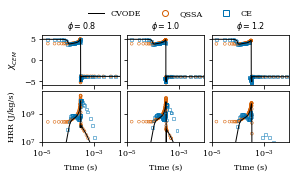

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- Paths and case info ---
QSSA_path = "../../figs/QSSA/data/"
RCCE_path = "../../figs/RCCE_fortran/data/"
data_dir  = "../../data"
case_name = "case_NH3_0D"
fig_dir = "../../figs/NH3_0Dignition"

# --- Plot styling arrays ---
line_arr   = ('-', '--', '-.', ':')
color_arr  = ('k', 'r', 'b', 'y', 'g', 'c', 'm')
symbol_arr = ('s', 'o', 'v', '^', '*')

# Original arrays for columns:
target_case_assemble = [
    'N_HR_1',
    'N_HR_2',
    'N_HR_3',
    'N_HR_4',
]
name_case_assemble = [
    r'$\phi = 0.5$',
    r'$\phi = 0.8$',
    r'$\phi = 1.0$',
    r'$\phi = 1.2$',
]

# >>> Modification Start <<<
# Remove the first column subfigures by slicing out the first element of each list.
target_case_assemble = target_case_assemble[1:]
name_case_assemble = name_case_assemble[1:]
# >>> Modification End <<<

# --- Top row species (left axis only) ---
top_row_left_cols = ['NH3', 'O2', 'H2', 'H2O']

# --- Lower rows ---
# We are no longer using the 'CEM' column here
data_cols = [ 'CEM', 'Qdot']

# --- Parameters for scatter symbol edge colors ---
qssa_marker_edge_color = '#D55E00'  # Parameter for QSSA symbol edge color
ceq_marker_edge_color  = '#0072B2'   # Parameter for CE (RCCE) symbol edge color

x_range   = [1e-5, 1e-2]
T_range = [1400, 2800]  # Set the T range here

range_cols = {
    'CEM': (-6, 6),
    'OH': (0, 0.035 ),
    'O': (0, 1.2e-2),
    'H': (0, 2.3e-2),
    'NO': (1e-4, 0.18),
    'Qdot': (1e7, 5e10)
    }

log_cols   = {
    'Qdot': True,
}

plt.rcParams.update({'font.size': 8})

# Create subplots: top row + one row for each entry in data_cols
# Note that the number of columns now reflects the modified target_case_assemble.
fig, axs = plt.subplots(len(data_cols), 
                        len(target_case_assemble),
                        figsize=(4.73, 1.1 * (len(data_cols)))
                       )

########################################################################
# 2) Plot each of the lower rows: one row per data_col
#    For 'OH', we also plot 'T' on the right axis.
########################################################################
for col_idx, target_case in enumerate(target_case_assemble):
    # CSV paths
    original_data_path = os.path.join(data_dir, case_name, target_case) + ".csv"
    rcce_data_path     = os.path.join(RCCE_path, case_name, target_case, "predicted_X.csv")
    qssa_data_path     = os.path.join(QSSA_path, case_name, target_case, "predicted_X.csv")

    df_original = pd.read_csv(original_data_path)
    df_rcce     = pd.read_csv(rcce_data_path)
    df_qssa     = pd.read_csv(qssa_data_path)

    t = df_original['t'].to_numpy()

    for row_idx, col in enumerate(data_cols):
        ax = axs[row_idx, col_idx]  # row_idx+1 because row=0 was top

        # Plot CVODE for col (line plot)
        cvode_values = df_original[col].to_numpy()
        ax.plot(
            t,
            cvode_values,
            linestyle='-',
            linewidth=1,
            color='black',
            label='CVODE' if (col_idx == 0 and row_idx == 0) else ""
        )

        # Plot QSSA for col (scatter)
        if col in df_qssa.columns:
            qssa_values = df_qssa[col].to_numpy()
            ax.scatter(
                t[::25],
                qssa_values[::25],
                s=8,
                alpha=1,
                linewidths=0.5,
                marker='o',
                facecolors='none',
                edgecolors=qssa_marker_edge_color,
                label='QSSA' if (col_idx == 0 and row_idx == 0) else ""
            )

        # Plot RCCE (labeled as CE) for col (scatter)
        if col in df_rcce.columns:
            rcce_values = df_rcce[col].to_numpy()
            ax.scatter(
                t[::25],
                rcce_values[::25],
                s=8,
                linewidths=0.5,
                alpha=1,
                marker='s',
                facecolors='none',
                edgecolors=ceq_marker_edge_color,
                label='RCCE' if (col_idx == 0 and row_idx == 0) else ""
            )

        # SPECIAL CASE: For 'OH', also plot T on the right axis
        if col == 'OH':
            ax_right = ax.twinx()
            # Plot T from df_original (CVODE)
            T_cvode = df_original['T'].to_numpy()
            line_T, = ax_right.plot(
                t,
                T_cvode,
                linestyle='--',
                linewidth=1,
                color='red',   # or any color you want for T
                label='T (CVODE)' if (col_idx == 0 and row_idx == 0) else ""
            )
            # Optionally, if you have T in QSSA or RCCE, you can plot them similarly:
            if 'T' in df_qssa.columns:
                ax_right.scatter(
                    t[::25],
                    df_qssa['T'].to_numpy()[::25],
                    s=5,
                    alpha=1,
                    marker='o',
                    facecolors='none',
                    edgecolors='red',
                    label='T (QSSA)' if (col_idx == 0 and row_idx == 0) else ""
                )
            if 'T' in df_rcce.columns:
                ax_right.scatter(
                    t[::25],
                    df_rcce['T'].to_numpy()[::25],
                    s=5,
                    alpha=1,
                    marker='s',
                    facecolors='none',
                    edgecolors='#D55E00',
                    label='T (RCCE)' if (col_idx == 0 and row_idx == 0) else ""
                )

            # Set the T y-axis range
            ax_right.set_ylim(T_range)

            # Axis label for T only in the rightmost column (for cleanliness):
            if col_idx == len(target_case_assemble) - 1:
                ax_right.set_ylabel("T (K)", fontsize=8, color='red')
                ax_right.spines['right'].set_color('red')
                ax_right.tick_params(axis='y', which='both', colors='red')
            else:
                ax_right.set_yticks([])

        # Format the left axis
        ax.set_xscale('log')
        ax.set_xlim(x_range)
        ax.set_ylim(range_cols[col])

        # If col == 'Qdot', use log-scale in y
        if col == 'Qdot' and log_cols.get('Qdot', False):
            ax.set_yscale('log')
            
        # Only bottom row shows the x-axis label
        if row_idx == len(data_cols) - 1:
            ax.set_xlabel("Time (s)", fontsize=8)

        # Y-axis label only in the first column
        if col_idx == 0:
            if col == 'Qdot':
                ax.set_ylabel('HRR (J/kg/s)', fontsize=8)
            else:
                ax.set_ylabel(col, fontsize=8)

        # Axis label for T only in the rightmost column (for cleanliness):
        if row_idx ==0:
                ax.set_title(name_case_assemble[col_idx], fontsize=8)


        # Remove y-labels if not the first column
        if col_idx != 0:
            ax.set_yticklabels([])

        # Remove x-ticklabels if not in the bottom-most row of data_cols
        if row_idx != len(data_cols) - 1:
            ax.set_xticklabels([])

########################################################################
# 3) Add a legend across the top for CVODE, QSSA, RCCE (CE)
########################################################################
legend_handles = [
    Line2D([0], [0],
           linestyle='-',
           linewidth=1.0,
           color='black',
           label='CVODE'),
    Line2D([0], [0],
           marker='o',
           linestyle='None',
           markerfacecolor='none',
           markeredgecolor=qssa_marker_edge_color,
           label='QSSA'),
    Line2D([0], [0],
           marker='s',
           linestyle='None',
           markerfacecolor='none',
           markeredgecolor=ceq_marker_edge_color,
           label='CE')
]

plt.subplots_adjust(top=0.8, right=0.85, wspace=0.1, hspace=0.1)

fig.legend(
    handles=legend_handles,
    loc='upper center',
    ncol=3,
    fontsize=8,
    frameon=False,
    bbox_to_anchor=(0.5, 1)
)

# Save the figure (adjust the save directory as needed)
fig.savefig("figs/0D_compact_marker.pdf", dpi=300, bbox_inches='tight')
plt.show()

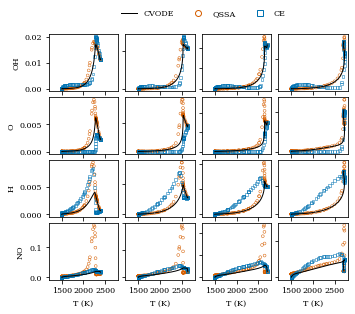

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- Paths and case info ---
QSSA_path = "../../figs/QSSA/data/"
RCCE_path = "../../figs/RCCE/data/"
data_dir  = "../../data"
case_name = "case_NH3_0D"
fig_dir = "../../figs/NH3_0Dignition"

# --- Plot styling arrays ---
line_arr   = ('-', '--', '-.', ':')
color_arr  = ('k', 'r', 'b', 'y', 'g', 'c', 'm')
symbol_arr = ('s', 'o', 'v', '^', '*')

target_case_assemble = [
    'N_HR_1',
    'N_HR_2',
    'N_HR_3',
    'N_HR_4',
]
name_case_assemble = [
    r'$\phi = 0.5$',
    r'$\phi = 0.8$',
    r'$\phi = 1.0$',
    r'$\phi = 1.2$',
]

# --- Data columns to be plotted (against temperature) ---
data_cols = ['OH', 'O', 'H', 'NO']

# --- Parameters for scatter symbol edge colors ---
qssa_marker_edge_color = '#D55E00'  # QSSA marker edge color
ceq_marker_edge_color  = '#0072B2'   # CE (RCCE) marker edge color

T_range = [1200, 2800]  # Updated Temperature range for x-axis

plt.rcParams.update({'font.size': 8})

# Create subplots: one row per data column
fig, axs = plt.subplots(len(data_cols), 
                        len(target_case_assemble),
                        figsize=(5.73, 1.1 * (len(data_cols)))
                       )

########################################################################
# Plot each row: one row per property (data_cols) against temperature T
########################################################################
for col_idx, target_case in enumerate(target_case_assemble):
    # CSV paths
    original_data_path = os.path.join(data_dir, case_name, target_case) + ".csv"
    rcce_data_path     = os.path.join(RCCE_path, case_name, target_case, "predicted_X.csv")
    qssa_data_path     = os.path.join(QSSA_path, case_name, target_case, "predicted_X.csv")

    df_original = pd.read_csv(original_data_path)
    df_rcce     = pd.read_csv(rcce_data_path)
    df_qssa     = pd.read_csv(qssa_data_path)

    # Use temperature from df_original as the x-axis variable
    T_vals = df_original['T'].to_numpy()

    for row_idx, col in enumerate(data_cols):
        ax = axs[row_idx, col_idx]  # No offset since top row is removed

        # Plot CVODE for col (line plot)
        cvode_values = df_original[col].to_numpy()
        ax.plot(
            T_vals,
            cvode_values,
            linestyle='-',
            linewidth=1,
            color='black',
            label='CVODE' if (col_idx == 0 and row_idx == 0) else ""
        )

        # Plot QSSA for col (scatter)
        if col in df_qssa.columns:
            qssa_values = df_qssa[col].to_numpy()
            ax.scatter(
                T_vals[::25],
                qssa_values[::25],
                s=8,
                alpha=1,
                linewidths=0.5,
                marker='o',
                facecolors='none',
                edgecolors=qssa_marker_edge_color,
                label='QSSA' if (col_idx == 0 and row_idx == 0) else ""
            )

        # Plot RCCE (labeled as CE) for col (scatter)
        if col in df_rcce.columns:
            rcce_values = df_rcce[col].to_numpy()
            ax.scatter(
                T_vals[::25],
                rcce_values[::25],
                s=8,
                linewidths=0.5,
                alpha=1,
                marker='s',
                facecolors='none',
                edgecolors=ceq_marker_edge_color,
                label='RCCE' if (col_idx == 0 and row_idx == 0) else ""
            )

        ax.set_xlim(T_range)

        if col == 'Qdot':
            ax.set_yscale('log')

        # Only the bottom row shows the x-axis label
        if row_idx == len(data_cols) - 1:
            ax.set_xlabel("T (K)", fontsize=8)

        # Set the y-axis label on the first column
        if col_idx == 0:
            ax.set_ylabel(col, fontsize=8)

        # Remove y-tick labels for non-first columns
        if col_idx != 0:
            ax.set_yticklabels([])

        # Remove x-tick labels for all but the bottom row
        if row_idx != len(data_cols) - 1:
            ax.set_xticklabels([])

########################################################################
# Add a legend across the top for CVODE, QSSA, and RCCE (labeled as CE)
########################################################################
legend_handles = [
    Line2D([0], [0],
           linestyle='-',
           linewidth=1.0,
           color='black',
           label='CVODE'),
    Line2D([0], [0],
           marker='o',
           linestyle='None',
           markerfacecolor='none',
           markeredgecolor=qssa_marker_edge_color,
           label='QSSA'),
    Line2D([0], [0],
           marker='s',
           linestyle='None',
           markerfacecolor='none',
           markeredgecolor=ceq_marker_edge_color,
           label='CE')
]

plt.subplots_adjust(top=0.90, right=0.85, wspace=0.1, hspace=0.1)

fig.legend(
    handles=legend_handles,
    loc='upper center',
    ncol=3,
    fontsize=8,
    frameon=False,
    bbox_to_anchor=(0.5, 1)
)

# Save the figure with the specified filename
fig.savefig("0D_CEQ_NH3_combine_Temperature_overall.pdf", dpi=300, bbox_inches='tight')
plt.show()

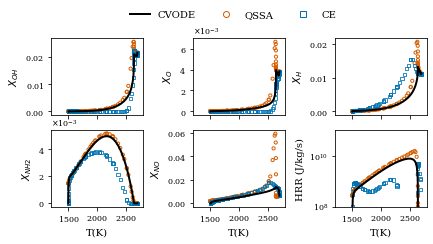

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker

# --- Paths and case info ---
qssa_method_path = "../../figs/QSSA/data/"
rcce_method_path = "../../figs/RCCE_fortran/data/"
fig_dir = "../../figs/NH3"
case_name = "case_NH3_0D"

target_case_assemble = [
    # 'N_HR_1',
    # 'N_HR_2',
    'N_HR_3',
    # 'N_HR_4',
]

# --- Initialize subplots (2 rows and 3 columns) ---
fig, axs = plt.subplots(2, 3, figsize=(6.73, 3), sharex=True)

data_cols = [ 'OH', 'O', 'H', 'NH2', 'NO','Qdot' ]

# --- Define color and marker parameters for QSSA and CE ---
qssa_color = '#D55E00'  # Parameter for QSSA symbol edge color
rcce_color  = '#0072B2'   # Parameter for CE (RCCE) symbol edge color

qssa_marker = 'o'     # Marker for QSSA (circle)
rcce_marker = 's'     # Marker for CE (square)

# Define y-axis ranges for each data column (optional)
range_cols = {
    'Qdot': (1e8, 1e11),  # Example range for Qdot (HRR)
    'NNH': (1e-8, 1e-2),  # Example range for Qdot (HRR)
    
}

for j, target_case in enumerate(target_case_assemble):
    # Define file paths
    original_data_path = os.path.join("../../data", case_name, target_case) + ".csv"
    rcce_data_path = os.path.join(rcce_method_path, case_name, target_case, "predicted_X.csv")
    qssa_data_path = os.path.join(qssa_method_path, case_name, target_case, "predicted_X.csv")

    # Read data
    df_original = pd.read_csv(original_data_path)
    df_rcce = pd.read_csv(rcce_data_path)
    df_qssa = pd.read_csv(qssa_data_path)

    # Ensure T is a NumPy array
    T = df_original['T'].to_numpy()

    # Plot each variable in its corresponding subplot
    for i, col in enumerate(data_cols):
        row, col_num = divmod(i, 3)
        ax = axs[row, col_num]
        
        # Use a line plot for CVODE (original) data
        ax.plot(
            T[::3], 
            df_original[col].to_numpy()[::3],
            label=f'{target_case}', 
            linewidth=2, 
            alpha=1, 
            color='black'
        )
        
        # Scatter plot for QSSA
        ax.scatter(
            T[::25], 
            df_qssa[col].to_numpy()[::25],
            s=10, 
            alpha=1,
            marker=qssa_marker,
            facecolors='none',
            edgecolors=qssa_color,
            label=f'QSSA - {target_case}'
        )
        
        # Scatter plot for CE (RCCE)
        ax.scatter(
            T[::25], 
            df_rcce[col].to_numpy()[::25],
            s=10, 
            alpha=0.8,
            marker=rcce_marker,
            facecolors='none',
            edgecolors=rcce_color,
            label=f'RCCE - {target_case}'
        )

        # Set log scale for Qdot (HRR) only
        if col == 'Qdot':
            ax.set_yscale('log')
            ax.set_ylabel('HRR (J/kg/s)', fontsize=10)
            if col in range_cols:
                ax.set_ylim(range_cols[col])
        else:
            ax.xaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
            ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
            ax.yaxis.get_major_formatter().set_powerlimits((-3, 3))
            ax.set_ylabel(r'$X_{' + col + '}$', fontsize=10)

        # # Axis label for T only in the rightmost column (for cleanliness):
        # if row_idx ==0:
        #         ax.set_title(name_case_assemble[col_idx], fontsize=8)

        ax.set_xlim([1200, 2800])
        if row == 1:
            ax.set_xlabel('T(K)', fontsize=10)

# Custom legend using a line for CVODE and markers for QSSA and CE
legend_handles = [
    Line2D([0], [0], color='black', linewidth=2, label='CVODE'),
    Line2D([0], [0], marker=qssa_marker, color='w', label='QSSA',
           markerfacecolor='none', markeredgecolor=qssa_color, markersize=6, linestyle='None'),
    Line2D([0], [0], marker=rcce_marker, color='w', label='CE',
           markerfacecolor='none', markeredgecolor=rcce_color, markersize=6, linestyle='None'),
]

fig.legend(
    handles=legend_handles, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.1), 
    ncol=3, 
    fontsize=10,
    frameon=False
)

plt.subplots_adjust(wspace=0.55, hspace=0.2, top=0.93, bottom=0.15)

os.makedirs(fig_dir, exist_ok=True)
plt.savefig(os.path.join(fig_dir, "0D_CEQ_NH3_combine_Temperature_overall.pdf"), dpi=300,bbox_inches='tight')
plt.show()